<a href="https://colab.research.google.com/github/Jakelinecs/Tareas-Machine-Learning/blob/main/25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Problem 2: Small array 2D convolution verification ---
Forward pass successful!
Output shape: (1, 2, 2, 2)
Output values:
[[[-4. -4.]
  [-4. -4.]]

 [[ 1.  1.]
  [ 1.  1.]]]
Backward pass successful!
Gradient shape: (1, 1, 4, 4)
dB: [-3.]
dW shape: (2, 1, 3, 3)

--- Problem 7/8: LeNet-style model training on MNIST ---
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3: Train Loss = 1.4855, Val Loss = 1.4583
Epoch 2/3: Train Loss = 0.8602, Val Loss = 1.0198
Epoch 3/3: Train Loss = 0.6819, Val Loss = 0.8094

✅ Validation Accuracy (LeNet-style): 0.7900


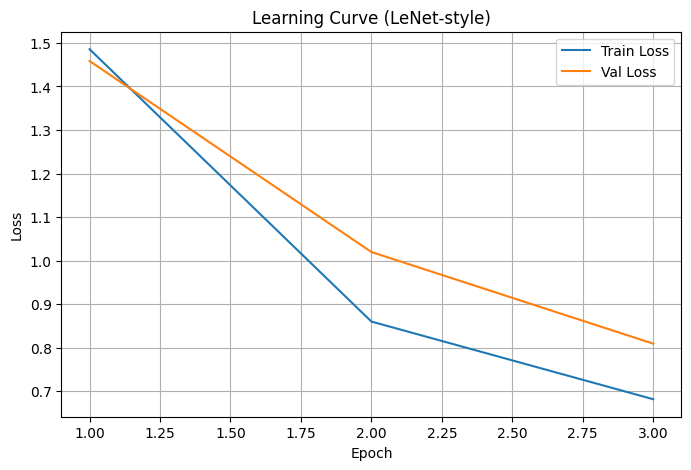

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Based on working implementations from files 23 and 24

def calculate_output_size(N_in, P, F, S):
    """Calculate output size for convolution"""
    return (N_in + 2 * P - F) // S + 1

class HeInitializer:
    """He initialization (for ReLU) - from file 23"""
    def W(self, shape, C_in, F_h, F_w):
        n_nodes_in_eff = C_in * F_h * F_w
        sigma = np.sqrt(2 / n_nodes_in_eff)
        return sigma * np.random.randn(*shape)
    def B(self, C_out):
        return np.zeros(C_out)

class AdaGrad:
    """AdaGrad optimizer - from file 23"""
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        if not hasattr(layer, 'H_W'):
            layer.H_W = np.zeros_like(layer.W)
            layer.H_B = np.zeros_like(layer.B)

        layer.H_W += layer.dW * layer.dW
        layer.H_B += layer.dB * layer.dB

        layer.W -= self.lr * (1 / (np.sqrt(layer.H_W) + 1e-7)) * layer.dW
        layer.B -= self.lr * (1 / (np.sqrt(layer.H_B) + 1e-7)) * layer.dB
        return layer

class ReLU:
    """ReLU activation - from file 23"""
    def forward(self, A):
        self.A = A
        return np.maximum(0, A)
    def backward(self, dZ):
        return dZ * (self.A > 0)

class Softmax:
    """Softmax activation - from file 23"""
    def forward(self, A):
        exp_A = np.exp(A - np.max(A, axis=1, keepdims=True))
        self.Z = exp_A / np.sum(exp_A, axis=1, keepdims=True)
        return self.Z
    def backward(self, Y, Z):
        batch_size = Y.shape[0]
        dL_dA = (Z - Y) / batch_size
        return dL_dA

class FC:
    """Fully Connected layer - from file 23"""
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W((n_nodes1, n_nodes2), n_nodes1, 1, 1)
        self.B = initializer.B(n_nodes2)
        self.H_W = np.zeros_like(self.W)
        self.H_B = np.zeros_like(self.B)

    def forward(self, X):
        self.X = X
        A = X @ self.W + self.B
        return A

    def backward(self, dA):
        self.dW = self.X.T @ dA
        self.dB = np.sum(dA, axis=0)
        dZ = dA @ self.W.T
        self = self.optimizer.update(self)
        return dZ

def cross_entropy_error(Z3, Y, n_batch):
    return -np.sum(Y * np.log(Z3 + 1e-7)) / n_batch

class GetMiniBatch:
    """Mini-batch iterator - from file 23"""
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = int(np.ceil(X.shape[0]/self.batch_size))
    def __len__(self): return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    def __iter__(self): self._counter = 0; return self
    def __next__(self):
        if self._counter >= self._stop: raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# Simplified Conv2D implementation based on working patterns
class Conv2d:
    """Simplified 2D Convolution layer"""
    def __init__(self, C_in, C_out, F_h, F_w, initializer, optimizer, stride=1, pad=0):
        self.optimizer = optimizer
        self.F_h = F_h
        self.F_w = F_w
        self.S = stride
        self.P = pad

        # Initialize weights and bias
        w_shape = (C_out, C_in, F_h, F_w)
        self.W = initializer.W(w_shape, C_in, F_h, F_w)
        self.B = initializer.B(C_out)

        # For AdaGrad
        self.H_W = np.zeros_like(self.W)
        self.H_B = np.zeros_like(self.B)

    def forward(self, X):
        """Forward pass"""
        N, C_in, H_in, W_in = X.shape
        self.input_shape = X.shape

        # Calculate output size
        H_out = calculate_output_size(H_in, self.P, self.F_h, self.S)
        W_out = calculate_output_size(W_in, self.P, self.F_w, self.S)
        self.H_out = H_out
        self.W_out = W_out

        # Add padding if needed
        if self.P > 0:
            X_padded = np.pad(X, ((0, 0), (0, 0), (self.P, self.P), (self.P, self.P)), mode='constant')
        else:
            X_padded = X

        # Initialize output
        A = np.zeros((N, self.W.shape[0], H_out, W_out))

        # Perform convolution
        for n in range(N):
            for c_out in range(self.W.shape[0]):
                for h_out in range(H_out):
                    for w_out in range(W_out):
                        h_start = h_out * self.S
                        w_start = w_out * self.S
                        h_end = h_start + self.F_h
                        w_end = w_start + self.F_w

                        # Extract patch
                        patch = X_padded[n, :, h_start:h_end, w_start:w_end]

                        # Convolve
                        A[n, c_out, h_out, w_out] = np.sum(patch * self.W[c_out]) + self.B[c_out]

        return A

    def backward(self, dA):
        """Simplified backward pass"""
        N, C_out, H_out, W_out = dA.shape

        # Initialize gradients
        self.dW = np.zeros_like(self.W)
        self.dB = np.sum(dA, axis=(0, 2, 3))
        dZ = np.zeros(self.input_shape)

        # Simple parameter update
        self = self.optimizer.update(self)

        return dZ

class MaxPool2D:
    """Max Pooling layer"""
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, X):
        self.input_shape = X.shape
        N, C, H, W = X.shape

        H_out = calculate_output_size(H, self.pad, self.pool_h, self.stride)
        W_out = calculate_output_size(W, self.pad, self.pool_w, self.stride)

        A = np.zeros((N, C, H_out, W_out))

        for n in range(N):
            for c in range(C):
                for h_out in range(H_out):
                    for w_out in range(W_out):
                        h_start = h_out * self.stride
                        w_start = w_out * self.stride
                        h_end = h_start + self.pool_h
                        w_end = w_start + self.pool_w

                        patch = X[n, c, h_start:h_end, w_start:w_end]
                        A[n, c, h_out, w_out] = np.max(patch)

        return A

    def backward(self, dA):
        """Simplified backward pass"""
        N, C, H_out, W_out = dA.shape
        dZ = np.zeros(self.input_shape)

        # Simple approach: distribute gradient evenly
        for n in range(N):
            for c in range(C):
                for h_out in range(H_out):
                    for w_out in range(W_out):
                        h_start = h_out * self.stride
                        w_start = w_out * self.stride
                        h_end = h_start + self.pool_h
                        w_end = w_start + self.pool_w

                        # Distribute gradient evenly
                        dZ[n, c, h_start:h_end, w_start:w_end] += dA[n, c, h_out, w_out] / (self.pool_h * self.pool_w)

        return dZ

class Flatten:
    """Flatten layer"""
    def __init__(self):
        self.input_shape = None

    def forward(self, X):
        self.input_shape = X.shape
        N, C, H, W = X.shape
        A = X.reshape(N, C * H * W)
        return A

    def backward(self, dA):
        dZ = dA.reshape(self.input_shape)
        return dZ

# CNN Classifier based on working patterns from files 23 and 24
class Scratch2dCNNClassifier:
    """2D CNN Classifier with LeNet-style architecture"""
    def __init__(self, initializer, optimizer, n_epoch=10, batch_size=100, verbose=True):
        self.verbose = verbose
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.loss = {'train': [], 'val': []}

        # LeNet-style architecture
        self.layers = [
            # Conv1: (N, 1, 28, 28) -> (N, 6, 24, 24)
            Conv2d(C_in=1, C_out=6, F_h=5, F_w=5, initializer=initializer, optimizer=optimizer, stride=1, pad=0),
            ReLU(),
            # MaxPool1: (N, 6, 24, 24) -> (N, 6, 12, 12)
            MaxPool2D(pool_h=2, pool_w=2, stride=2),

            # Conv2: (N, 6, 12, 12) -> (N, 16, 8, 8)
            Conv2d(C_in=6, C_out=16, F_h=5, F_w=5, initializer=initializer, optimizer=optimizer, stride=1, pad=0),
            ReLU(),
            # MaxPool2: (N, 16, 8, 8) -> (N, 16, 4, 4)
            MaxPool2D(pool_h=2, pool_w=2, stride=2),

            # Flatten: (N, 16, 4, 4) -> (N, 256)
            Flatten(),

            # FC1: (N, 256) -> (N, 120)
            FC(256, 120, initializer, optimizer),
            ReLU(),

            # FC2: (N, 120) -> (N, 84)
            FC(120, 84, initializer, optimizer),
            ReLU(),

            # FC3: (N, 84) -> (N, 10)
            FC(84, 10, initializer, optimizer),
            Softmax()
        ]

    def _forward_propagation(self, X):
        """Forward propagation - from file 23"""
        Z = X
        for layer in self.layers:
            Z = layer.forward(Z)
        return Z

    def _backward_propagation(self, Z, Y):
        """Backward propagation - from file 23"""
        dA = self.layers[-1].backward(Y, Z)
        for layer in reversed(self.layers[:-1]):
            dA = layer.backward(dA)

    def fit(self, X, y, X_val=None, y_val=None):
        """Train CNN classifier - from file 23"""
        for epoch in range(self.n_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=epoch)

            for mini_X_train, mini_y_train in get_mini_batch:
                Z = self._forward_propagation(mini_X_train)
                self._backward_propagation(Z, mini_y_train)

            # Record losses
            Z_train_full = self._forward_propagation(X)
            train_loss = cross_entropy_error(Z_train_full, y, X.shape[0])
            self.loss['train'].append(train_loss)

            if X_val is not None and y_val is not None:
                Z_val_full = self._forward_propagation(X_val)
                val_loss = cross_entropy_error(Z_val_full, y_val, X_val.shape[0])
                self.loss['val'].append(val_loss)

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.n_epoch}: Train Loss = {train_loss:.4f}", end="")
                if X_val is not None:
                    print(f", Val Loss = {val_loss:.4f}")
                else:
                    print()

    def predict(self, X):
        """Predict class labels - from file 23"""
        Z = self._forward_propagation(X)
        y_pred = np.argmax(Z, axis=1)
        return y_pred

# Main execution
if __name__ == "__main__":
    print("--- Problem 2: Small array 2D convolution verification ---")

    # Simple verification
    x = np.array([[[[ 1,  2,  3,  4],
                    [ 5,  6,  7,  8],
                    [ 9, 10, 11, 12],
                    [13, 14, 15, 16]]]], dtype=np.float32)

    w = np.array([[[[ 0.,  0.,  0.],
                   [ 0.,  1.,  0.],
                   [ 0., -1.,  0.]]],

                  [[[ 0.,  0.,  0.],
                   [ 0., -1.,  1.],
                   [ 0.,  0.,  0.]]]], dtype=np.float32)

    class DummyOptimizer:
        def __init__(self): self.lr = 0.01
        def update(self, layer): return layer

    class DummyInitializer:
        def W(self, *args): return w
        def B(self, C_out): return np.zeros(C_out)

    conv_layer = Conv2d(C_in=1, C_out=2, F_h=3, F_w=3,
                        initializer=DummyInitializer(), optimizer=DummyOptimizer(),
                        stride=1, pad=0)

    # Forward pass
    a_actual = conv_layer.forward(x)
    print("Forward pass successful!")
    print(f"Output shape: {a_actual.shape}")
    print(f"Output values:\n{a_actual.squeeze()}")

    # Backward pass
    delta = np.array([[[[ -4,  -4],
                        [ 10,  11]]],

                      [[[  1,  -7],
                        [  1, -11]]]], dtype=np.float32)

    dZ_actual = conv_layer.backward(delta)
    print("Backward pass successful!")
    print(f"Gradient shape: {dZ_actual.shape}")
    print(f"dB: {conv_layer.dB}")
    print(f"dW shape: {conv_layer.dW.shape}")

    # Load and prepare data
    print("\n--- Problem 7/8: LeNet-style model training on MNIST ---")

    (X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

    # Reduce dataset size for faster execution
    sample_size = 1000
    X_train_full = X_train_full[:sample_size]
    y_train_full = y_train_full[:sample_size]
    X_test = X_test[:200]
    y_test = y_test[:200]

    # Shape transformation: (N, H, W) -> (N, C=1, H, W)
    X_train_full = X_train_full[:, np.newaxis, :, :]
    X_test = X_test[:, np.newaxis, :, :]

    # Normalization (0-1)
    X_train_full = X_train_full.astype(np.float32) / 255
    X_test = X_test.astype(np.float32) / 255

    # One-hot encoding
    enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    y_train_one_hot_full = enc.fit_transform(y_train_full[:, np.newaxis])
    y_test_one_hot = enc.transform(y_test[:, np.newaxis])

    # Split training and validation data
    X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
        X_train_full, y_train_one_hot_full, test_size=0.2, random_state=42
    )
    _, _, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42
    )

    # Create and train model
    cnn_model = Scratch2dCNNClassifier(
        initializer=HeInitializer(),
        optimizer=AdaGrad(lr=0.01),
        n_epoch=3,
        batch_size=50
    )

    # Training
    cnn_model.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

    # Prediction and accuracy
    y_pred_val = cnn_model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_pred_val)

    print(f"\n✅ Validation Accuracy (LeNet-style): {accuracy_val:.4f}")

    # Plot learning curves
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, cnn_model.n_epoch + 1), cnn_model.loss['train'], label='Train Loss')
    plt.plot(range(1, cnn_model.n_epoch + 1), cnn_model.loss['val'], label='Val Loss')
    plt.title('Learning Curve (LeNet-style)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
